In [1]:
source('../../functions.R')
eos = readRDS('Data/eosinophil_seurat.RDS')
seurat = readRDS('Data/tissue_seurat.RDS')
setwd('Figures/Figure 2')

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

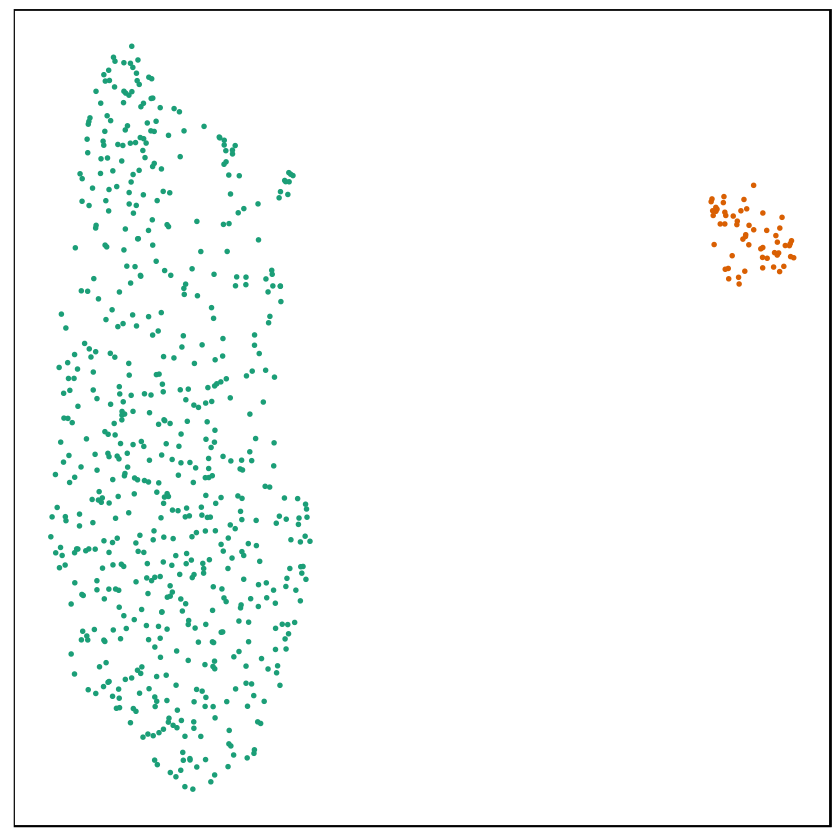

In [2]:
# Panel 2b: Eosinophils vs neutrophils UMAP
ggplot(eos@meta.data, aes(x = UMAP1, y = UMAP2, color = sub_phenotype)) + geom_point(size = .5) + UMAP_theme + 
scale_color_brewer(palette ='Dark2')
ggsave('phenotype_umap.pdf', width = 2, height = 2, useDingbats = FALSE)

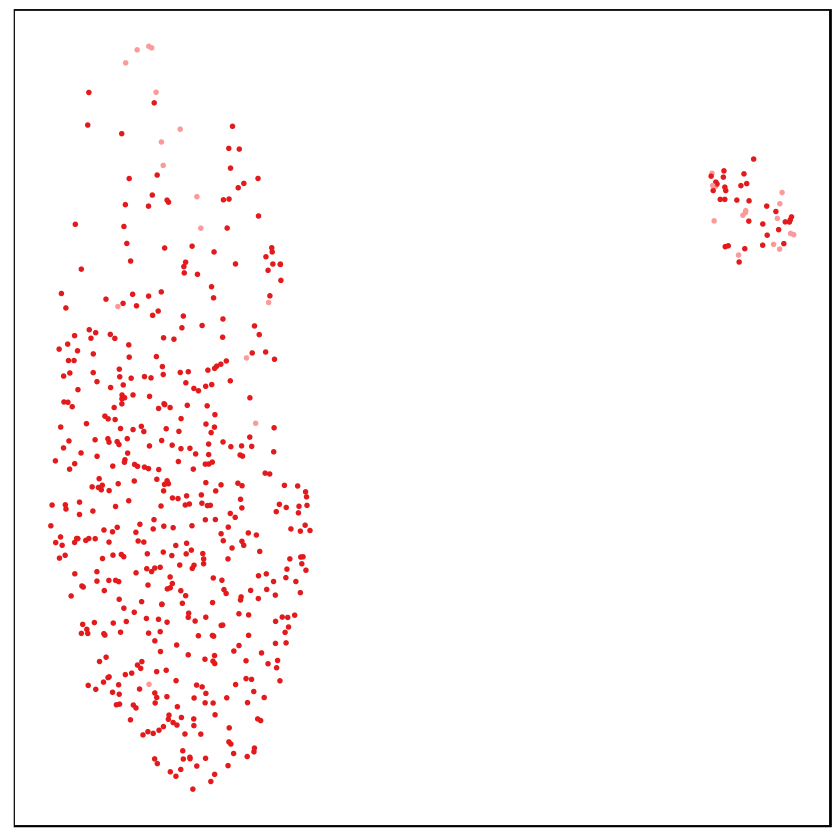

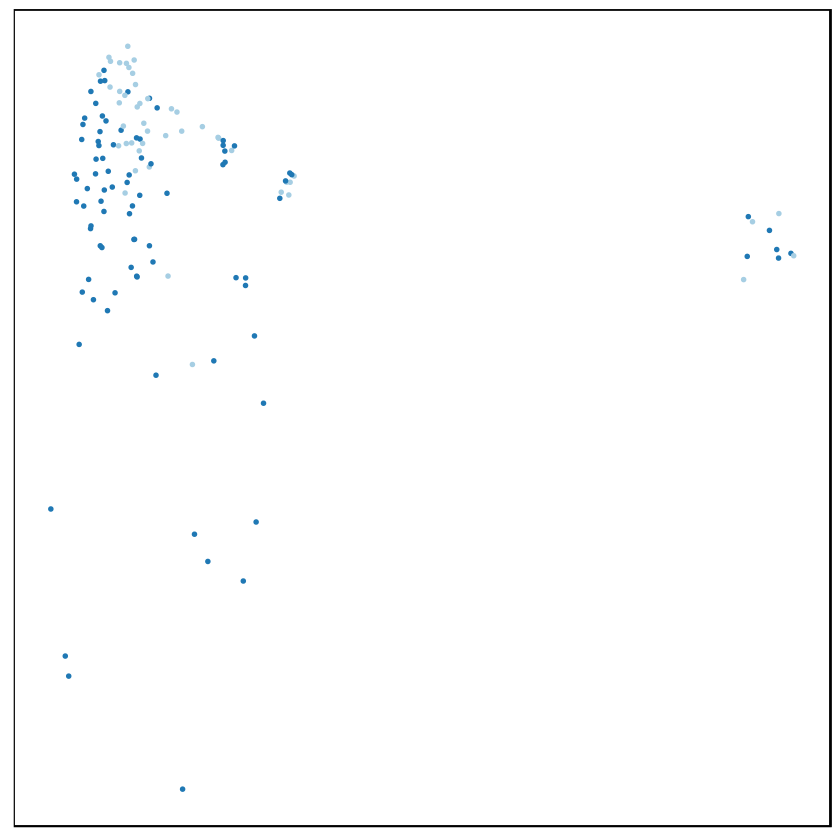

In [3]:
# Panel 2a: UMAP colored by tissue + diagnosis
ggplot(eos@meta.data %>% filter(tissue == 'Esophagus'), aes(x = UMAP1, y = UMAP2, color = ci)) + geom_point(size = .5) + UMAP_theme + 
scale_color_manual(values = tissue_palette)
ggsave('esophagus_umap.pdf', width = 2, height = 2, useDingbats = FALSE)

ggplot(eos@meta.data %>% filter(tissue == 'Duodenum'), aes(x = UMAP1, y = UMAP2, color = ci)) + geom_point(size = .5) + UMAP_theme + 
scale_color_manual(values = tissue_palette)
ggsave('duodenum_umap.pdf', width = 2, height = 2, useDingbats = FALSE)

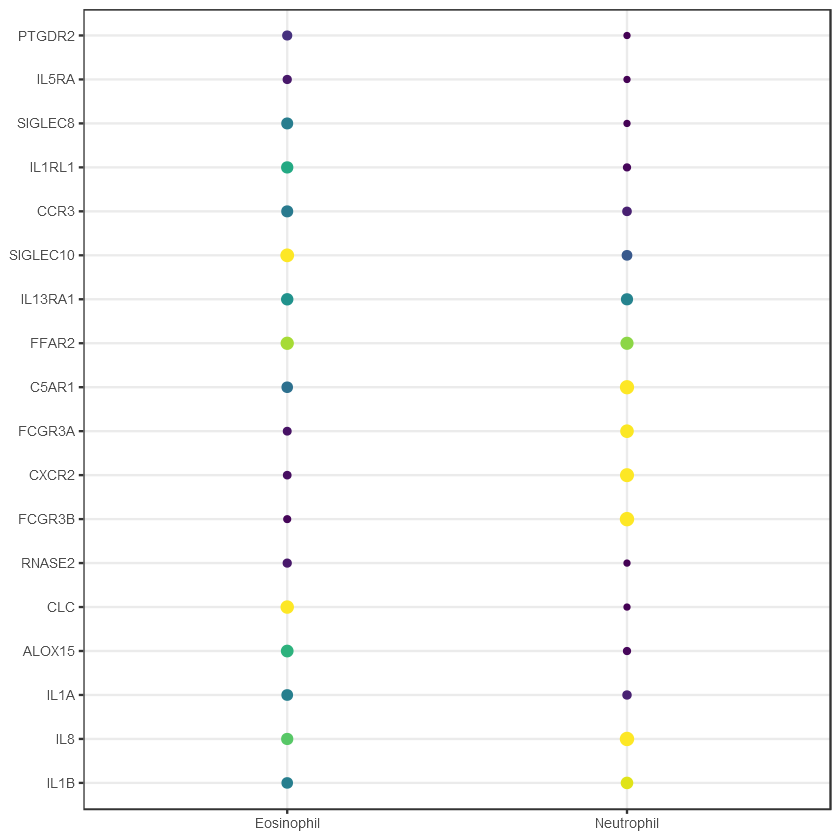

In [4]:
# Panel 3: phenotype of eosinophils and neutrophils

genes1 = c('SIGLEC8', 'CCR3', 'IL5RA', 'CXCR2', 'FCGR3A', 'FCGR3B', 'C5AR1', 'FFAR2', 'IL1RL1', 'IL13RA1','SIGLEC10', 'PTGDR2')
 genes2 = c('CLC', 'RNASE2', 'ALOX15', 'IL1A', 'IL1B', 'IL8')
 
data = as.data.frame(t(as.matrix(eos@data[c(genes1, genes2),])))
data$phenotype = eos@meta.data$sub_phenotype
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 2] = 2
df_exp$pct = df_pct$value
df_exp$value[is.nan(df_exp$value)] = 0


sub1 = df_exp %>% filter(variable %in% genes1)
order1 = sub1$value[sub1$phenotype == 'Eosinophil']/sub1$value[sub1$phenotype == 'Neutrophil']
order1 = sub1$variable[order(order1)*2] %>% as.character() %>% rev()

sub2 = df_exp %>% filter(variable %in% genes2)
order2 = sub2$value[sub2$phenotype == 'Eosinophil']/sub2$value[sub2$phenotype == 'Neutrophil']
order2 = sub2$variable[order(order2)*2] %>% as.character() %>% rev()


ggplot(df_exp, aes(x = phenotype, y = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
scale_y_discrete(limits = rev(c(order1, order2))) + theme_bw()  + scale_size(range = c(1,3)) + 
labs(color = "Mean expression", size = 'Fraction of cells\nexpressing') + Axis_themes+ theme(axis.title = element_blank(), axis.text = element_text(size = 8), axis.text.x = element_text(size = 8)) + guides(color = FALSE, size = FALSE)
#ggsave('markergenes.eps', width = 3, height =3)
ggsave('markergenes.pdf', width = 1.7, height =2.5, useDingbats = FALSE)

Warning message:
"package 'ggbeeswarm' was built under R version 3.5.3"

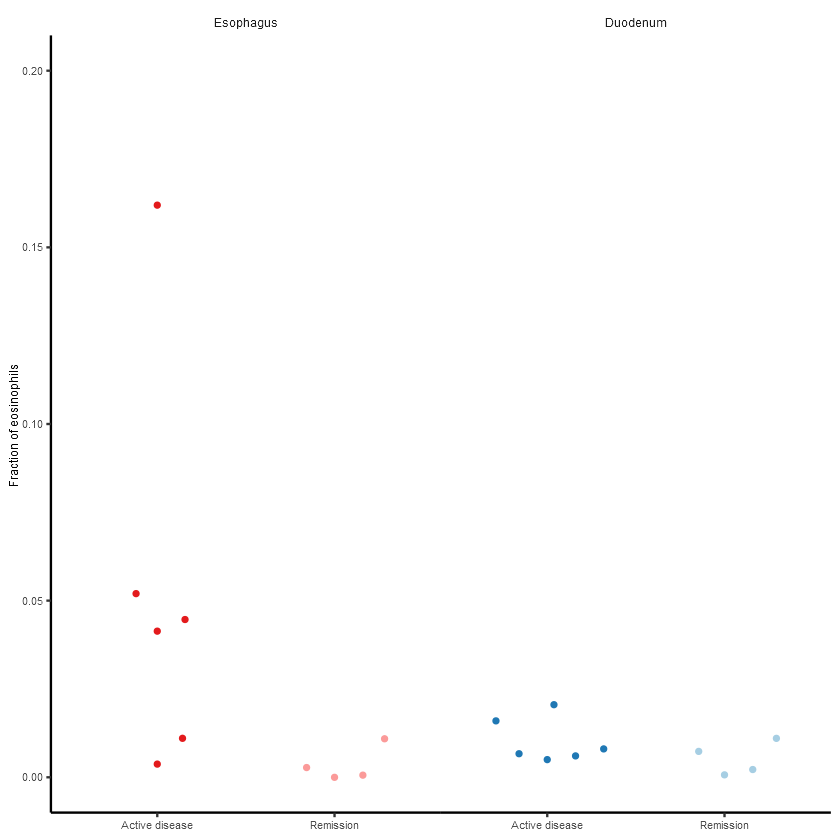

In [5]:
# Figure 2D: Fraction of eosinophils in disease vs. remission, esophagus vs. duodenum
set.seed(1)
library(ggbeeswarm)
seurat@meta.data$eosinophil = as.numeric(seurat@cell.names %in% eos@cell.names[eos@meta.data$sub_phenotype == 'Eosinophil'])
df = seurat@meta.data %>% group_by(ci, patient, diagnosis, tissue) %>% summarize(neos = sum(eosinophil == 1), ntotal = n()) %>% 
    mutate(p_eos = neos/ntotal) 
df$tissue = factor(as.character(df$tissue), levels = c("Esophagus", 'Duodenum'))
df$diagnosis = as.character(df$diagnosis)
df$diagnosis[df$diagnosis == 'Diseased'] = 'Active disease'
ggplot(df, aes(x = diagnosis, y = p_eos, color = ci)) + geom_beeswarm(size = 1, cex = 8) + facet_grid(~tissue, space = 'free')  + theme_bw() + Axis_themes+ 
    labs(y ='Fraction of eosinophils') + 
    theme(axis.title.x = element_blank(), strip.background = element_blank(), axis.line = element_line(color = 'black', size = .5),   panel.border = element_blank(),
          panel.background = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(), strip.text.x = element_text(size = 7),
          panel.spacing = unit(0, "mm")) +
    scale_y_continuous(expand = c(0, 0.01), limits = c(0, .2)) +
    scale_color_manual(values = tissue_palette) + guides(color = FALSE) 
write.csv(df, '2d.csv')
ggsave('proportion_comparison.pdf', height = 2.4, width = 1.8, useDingbats = FALSE)

In [6]:
 df %>% filter(tissue == 'Esophagus')

ci,patient,diagnosis,tissue,neos,ntotal,p_eos
Diseased_E,292,Active disease,Esophagus,30,577,0.0519930676
Diseased_E,354,Active disease,Esophagus,116,2597,0.0446669234
Diseased_E,451,Active disease,Esophagus,7,634,0.0110410095
Diseased_E,471,Active disease,Esophagus,3,802,0.0037406484
Diseased_E,474,Active disease,Esophagus,199,4810,0.0413721414
Diseased_E,475,Active disease,Esophagus,126,778,0.1619537275
Remission_E,249,Remission,Esophagus,12,1100,0.0109090909
Remission_E,355,Remission,Esophagus,2,724,0.0027624309
Remission_E,392,Remission,Esophagus,1,1638,0.0006105006
Remission_E,468,Remission,Esophagus,0,732,0.0000000000


In [7]:
wilcox.test(p_eos~diagnosis, data = df %>% filter(tissue == 'Esophagus'))
wilcox.test(p_eos~diagnosis, data = df %>% filter(tissue == 'Duodenum'))


	Wilcoxon rank sum test

data:  p_eos by diagnosis
W = 23, p-value = 0.01905
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test

data:  p_eos by diagnosis
W = 17, p-value = 0.3524
alternative hypothesis: true location shift is not equal to 0


`geom_smooth()` using formula 'y ~ x'


`geom_smooth()` using formula 'y ~ x'


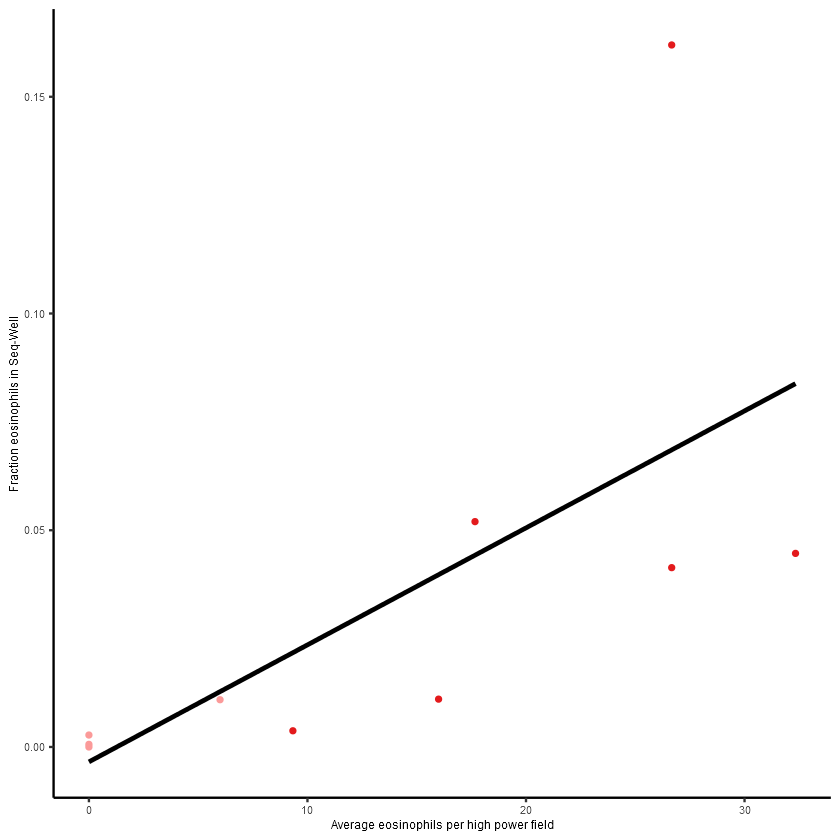

In [8]:
# Figure 2e: correlation between eos in pathology and eos in Seq-Well

# read eos data, compute average eos/hpf
counts = read.csv('eocounts.csv', row.names = 1, stringsAsFactors = FALSE)
counts$avg = apply(counts, 1, function(x) sum(x)/3)
    
    
df = seurat@meta.data %>% group_by(ci, patient, diagnosis, tissue) %>% summarize(neos = sum(eosinophil == 1), ntotal = n()) %>% 
    mutate(p_eos = neos/ntotal) %>% filter(tissue == 'Esophagus') %>% as.data.frame()
rownames(df) = df$patient
df$path = counts[as.character(df$patient), 'avg']
    
ggplot(df, aes(x = path, y = p_eos, color = ci)) + geom_point(size = 1) + geom_smooth(method = 'lm', se= FALSE, color = 'black') + theme_bw() + remove_grid + Axis_themes + 
    labs(x = "Average eosinophils per high power field", y = 'Fraction eosinophils in Seq-Well') + scale_color_manual(values = tissue_palette) + 
    guides(color = FALSE) + 
                   theme( panel.border = element_blank(),
    panel.background = element_blank(), axis.line = element_line(color = 'black', size = .5))
ggsave('eoscatterplot.pdf', height = 2.3, width = 2.3, useDingbats = FALSE)
write.csv(df, 'fig2e.csv')

In [9]:
fit = lm(p_eos~path, data = df)
summary(fit)
cor.test(df$path, df$p_eos, method = 'spearman')


Call:
lm(formula = p_eos ~ path, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.039151 -0.024868  0.000795  0.005660  0.093427 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.003436   0.018982  -0.181   0.8609  
path         0.002699   0.001068   2.527   0.0354 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03917 on 8 degrees of freedom
Multiple R-squared:  0.4438,	Adjusted R-squared:  0.3743 
F-statistic: 6.384 on 1 and 8 DF,  p-value: 0.03544


Warning message in cor.test.default(df$path, df$p_eos, method = "spearman"):
"Cannot compute exact p-value with ties"


	Spearman's rank correlation rho

data:  df$path and df$p_eos
S = 16.736, p-value = 0.0004091
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8985679 


In [10]:
ind = which(seurat@meta.data$tissue == 'Esophagus' & seurat@meta.data$diagnosis == 'Diseased')
sum(seurat@meta.data$eosinophil[ind])/length(ind)

[1] 0.04716611

In [11]:
# pathway scoring
library(fgsea)
library(GSA)
hallmark = GSA.read.gmt("hallmark.gmt")
for (i in 1:length(hallmark$geneset.names)) {
  eos = AddModuleScore(eos, genes.list = hallmark[[1]][i], enrich.name = hallmark$geneset.names[i])
}

Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.5.3"Warning message:
"package 'GSA' was built under R version 3.5.2"

12345678910111213141516171819202122232425262728293031323334353637383940414243444546474849501
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [12]:
# determine pathways most upregulated by eosinophils
pvals =c()
ind1 = which(eos@meta.data$sub_phenotype == 'Eosinophil' & eos@meta.data$ci == 'Diseased_E')
ind2 = which(eos@meta.data$sub_phenotype == 'Eosinophil' & eos@meta.data$tissue == 'Duodenum')

for (i in 1:length(hallmark$geneset.names)) {
  data = eos@meta.data[,paste0(hallmark$geneset.names[i],1)]
  result = wilcox.test(data[ind1], data[ind2], alternative = 'greater')
  pvals = c(pvals, result$p.value)
}
df = data.frame(path = hallmark$geneset.names, pvals = pvals)
df = df[order(df$pvals),]
df$origin = 'hallmark'
df$path = as.character(df$path)
df$path = gsub(df$path, pattern = 'HALLMARK_', replacement = '')
df$pvals = p.adjust(df$pvals)
df = df[order(df$pvals),]
write.csv(df, '2f.csv')
df = df[1:10,]


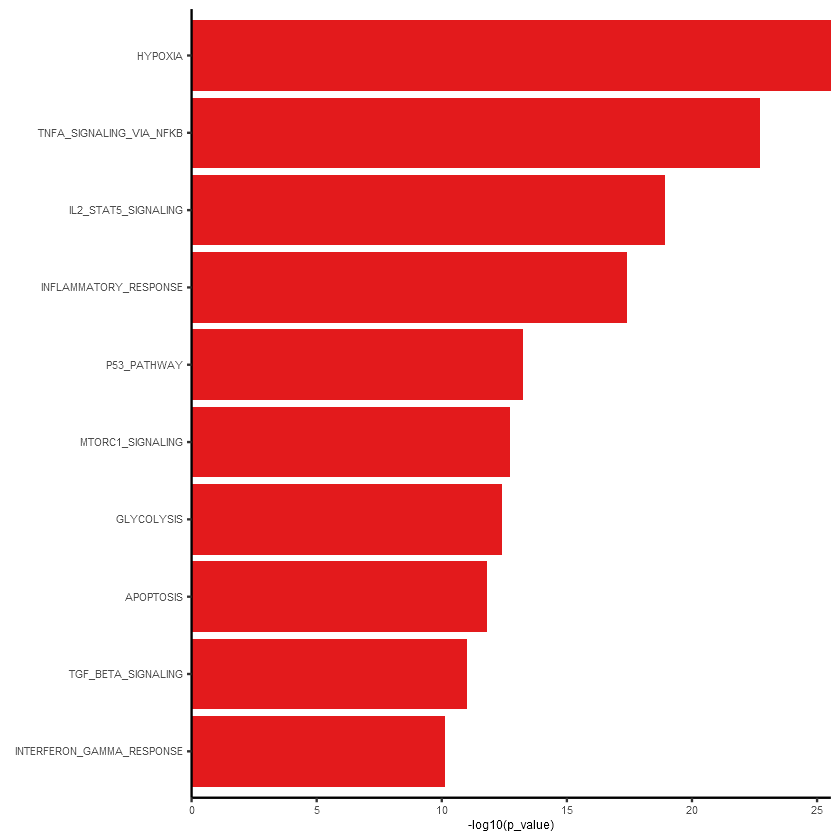

In [13]:
ggplot(df, aes(y = -log10(pvals), x = path, fill = '1')) + geom_col() + coord_flip() +
  scale_x_discrete(limits = rev(df$path)) + scale_y_continuous(expand = c(0,0)) +
  scale_fill_manual(values =  brewer.pal(6,'Paired')[6]) + theme_classic() + 
  guides(fill = FALSE) + 
  labs(y = '-log10(p_value)', x = element_blank()) +
  Axis_themes
ggsave('pathways.pdf', height = 2, width = 3, useDingbats = FALSE)

In [14]:
# read in results of SCENIC analysis
tab = read.csv('auc_mtx_eo.csv', header = 1, stringsAsFactors = FALSE)
head(tab)

Cell,ALX4...,ARID3A...,ARNTL...,ARNTL2...,ATF3...,ATF4...,ATF6...,BACH2...,BARX2...,...,ZNF605...,ZNF607...,ZNF621...,ZNF646...,ZNF8...,ZNF845...,ZNF846...,ZNF853...,ZNF90...,ZNF91...
468-D1_858,0.00810098,0.154860588,0.04692359,0.007215123,0.04541308,0.21247572,0.01108205,0.06874700,0.00000000,...,0.00000000,0.0822238968,0.19658377,0.1302437,0.0000000,0.008666164,0.00000000,0.15895145,0.0000000,0.026584610
249-D_1380,0.00000000,0.080633007,0.05757454,0.055139573,0.10524333,0.13139919,0.00000000,0.03815853,0.24403416,...,0.00000000,0.0661893996,0.12077367,0.0000000,0.0000000,0.000000000,0.03933685,0.05592636,0.0000000,0.065896341
468-D1_401,0.00000000,0.005740503,0.06841122,0.050682230,0.06907151,0.14148961,0.05137639,0.03257519,0.18881353,...,0.12498654,0.0494431885,0.07586034,0.0000000,0.1107762,0.000000000,0.13006782,0.09398213,0.1976890,0.003977225
249-D_1555,0.00000000,0.042887539,0.06517401,0.067645786,0.21941062,0.10889426,0.07948047,0.03195862,0.21644478,...,0.01065777,0.1223310726,0.05671942,0.1331324,0.0000000,0.000000000,0.06797287,0.03111207,0.1233358,0.022021268
249-D_3727,0.00000000,0.101046146,0.06047741,0.052750565,0.07375164,0.09201624,0.04650029,0.00000000,0.15716319,...,0.03993971,0.0002093276,0.00000000,0.0000000,0.0000000,0.001883949,0.10972118,0.06970610,0.0000000,0.086829105
451-ES_387,0.17596081,0.035196596,0.02901812,0.030255415,0.02300401,0.10757583,0.05656279,0.04326231,0.01251779,...,0.03767898,0.0000000000,0.03943733,0.1626476,0.0000000,0.000000000,0.10640543,0.05275057,0.0000000,0.000000000


In [15]:
library(stringr)
eos = SubsetData(eos, eos@cell.names[eos@meta.data$sub_phenotype == 'Eosinophil'])
tab$diag = eos@meta.data[tab$Cell, 'diagnosis']
tab$tissue = eos@meta.data[tab$Cell, 'tissue']



Warning message:
"package 'stringr' was built under R version 3.5.3"


 Duodenum Esophagus 
      126       496 

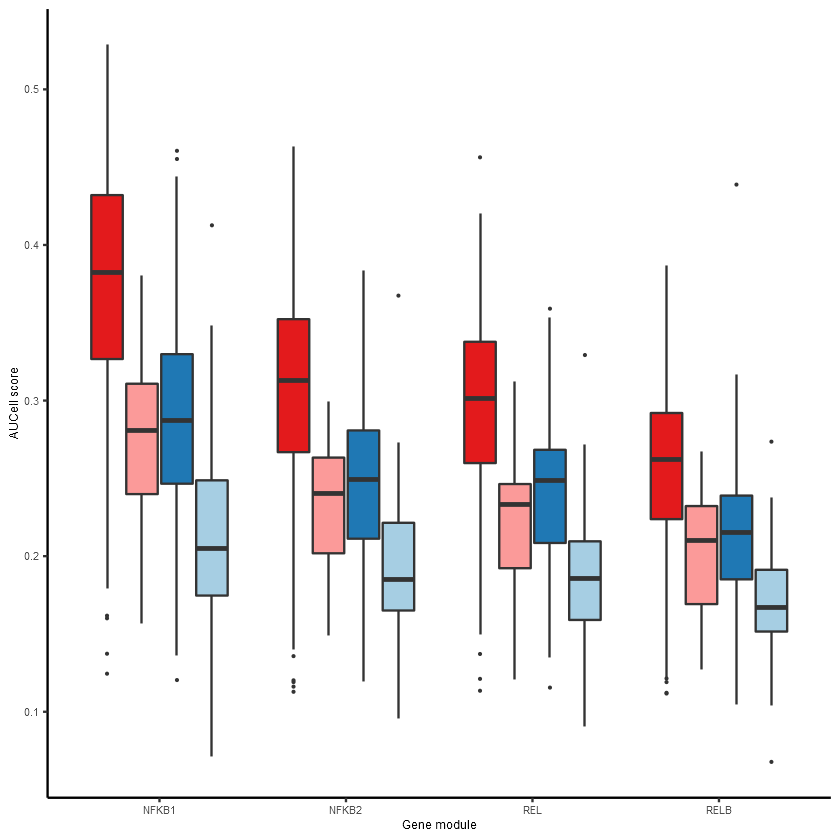

In [16]:
tab_sub = tab[eos@meta.data$sub_phenotype == 'Eosinophil',]
rownames(tab_sub) = tab$Cell

colnames(tab_sub)[2:255] = sapply(colnames(tab_sub)[2:255], function(x) substring(x, 1, str_length(x) - 3))
tab_sub$tissue = eos@meta.data[rownames(tab_sub), 'tissue']
tab_sub$diag = eos@meta.data[rownames(tab_sub), 'diagnosis']
table(tab_sub$tissue)
    
tab_sub$ci = paste0(tab_sub$tissue, tab_sub$diag)
tab_sub$ci = factor(tab_sub$ci, levels = c("EsophagusDiseased", 'EsophagusRemission', 'DuodenumDiseased', 'DuodenumRemission'))
tab_sub = tab_sub %>% dplyr::select(ci, NFKB1, NFKB2, REL, RELB)
df = melt(tab_sub, id = 'ci')
#ggplot(df, aes(x = variable, y = value, fill = ci)) + geom_violin(width = .6,  trim = FALSE) + scale_fill_manual(values = unname(tissue_palette)[c(3,4,1,2)]) + theme_classic() + guides(fill = FALSE)
ggplot(df, aes(x = variable, y = value, fill = ci)) + geom_boxplot(outlier.size = 0.1, size = .5) + scale_fill_manual(values = unname(tissue_palette)[c(3,4,1,2)]) + theme_classic() + guides(fill = FALSE) + 
#stat_compare_means(aes(x = variable, y = value, group = ci, fill = ci), comparisons = list(c(1,2))) +
labs(x = 'Gene module', y = 'AUCell score') + Axis_themes
ggsave('nfkb.pdf', height = 2, width = 3, useDingbats = FALSE)

In [17]:
pval = c()
pval_less = c()
for (i in 2:255) {
    result = wilcox.test(tab[,i][tab$diag == 'Diseased' & tab$tissue == 'Esophagus'],tab[,i][tab$tissue == 'Duodenum'])
    pval = c(pval, result$p.value)

}
names(pval) = colnames(tab)[2:255]
#pval=pval[order(pval)]
#head(pval)
pval = p.adjust(pval, method = 'bonferroni')

df = data.frame(row.names = names(pval), pval = pval, label = names(pval))
df = df[order(df$pval, decreasing = FALSE),]
head(df)

,pval,label
NFKB1...,3.513235e-31,NFKB1...
TGIF1...,2.759509e-27,TGIF1...
REL...,9.446868e-27,REL...
HIVEP1...,4.125480e-26,HIVEP1...
NFKB2...,6.521613e-26,NFKB2...
RBPJ...,2.614909e-25,RBPJ...


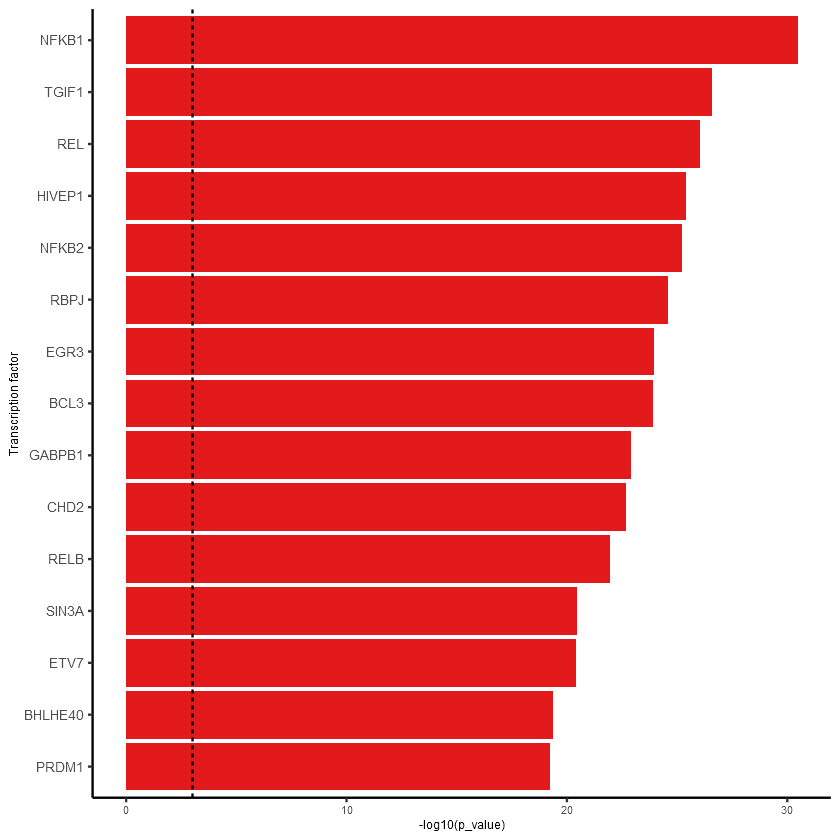

In [18]:
library(stringr)
df$tf = rownames(df) 
df$tf = sapply(df$tf, function(x) substring(x, first = 1, last = str_length(x)-3))
ggplot(df[1:15,], aes(y = -log10(pval), x = tf)) + geom_col(fill =tissue_palette[3]) + coord_flip() +
  scale_fill_manual(values =  brewer.pal(6,'Paired')[6]) + theme_classic() + 
    scale_x_discrete(limits = rev(df$tf[1:15])) +
  labs(y = '-log10(p_value)', x = 'Transcription factor') +
  Axis_themes + theme(axis.text.y = element_text(size = 8)) + geom_hline(yintercept = 3, color = 'black', linetype = 'dashed')
ggsave('tfs.pdf', height = 3, width = 3, useDingbats = FALSE)
